In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans

In [5]:
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')

100% [............................................................................] 115774 / 115774
Data downloaded!


In [6]:
# open & load downloaded file, print its type
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [7]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


In [8]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


In [9]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

In [10]:
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [11]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [14]:
map_newyork = folium.Map(location=[latitude, longitude], tiles='StamenToner',zoom_start=12)


# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label,max_width='100%', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)
folium.LayerControl().add_to(map_newyork)

In [15]:
map_newyork

In [16]:
CLIENT_ID = 'M0SXG5OSZBU3F45PELE5DMDJHD1QVOBLTKVP1C2QO24LGEUI' # your Foursquare ID
CLIENT_SECRET = 'MKIH3DXRLL4MTL43NVYAYCNHFD0OMBFVSA4XBN5PSM1LD55W' # your Foursquare Secret
VERSION = '20180605'

In [17]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION)
category_results = requests.get(url).json()

In [18]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 16373


In [19]:
category_list = category_results['response']['categories']

In [20]:
len(category_list)

10

In [21]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [22]:
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict


In [23]:
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [24]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

In [25]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [26]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/search?&client_id=M0SXG5OSZBU3F45PELE5DMDJHD1QVOBLTKVP1C2QO24LGEUI&client_secret=MKIH3DXRLL4MTL43NVYAYCNHFD0OMBFVSA4XBN5PSM1LD55W&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [27]:
results = requests.get(url).json()

In [28]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665},
    {'label': 'entrance', 'lat': 40.890438, 'lng': -73.848559}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1622511396',
  'hasPerk': False}]

In [29]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [30]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [31]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [32]:
print(nyc_venues.shape)
nyc_venues.head()

(13816, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
3,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889503,-73.843389,Fried Chicken Joint
4,Wakefield,40.894705,-73.847201,Dunkin',40.893064,-73.856977,Donut Shop


In [33]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 209 uniques categories.


Venue Category
Deli / Bodega                               1104
Pizza Place                                 1016
Coffee Shop                                  850
Bakery                                       634
Donut Shop                                   629
Chinese Restaurant                           611
Italian Restaurant                           562
Fast Food Restaurant                         525
Café                                         447
Caribbean Restaurant                         379
Mexican Restaurant                           371
American Restaurant                          355
Bagel Shop                                   328
Ice Cream Shop                               314
Fried Chicken Joint                          305
Sandwich Place                               266
Diner                                        258
Restaurant                                   222
Food                                         201
Seafood Restaurant                           188
Burge

In [34]:
unique_categories = nyc_venues['Venue Category'].unique().tolist()

In [35]:
unique_categories

['Dessert Shop',
 'Ice Cream Shop',
 'Fast Food Restaurant',
 'Fried Chicken Joint',
 'Donut Shop',
 'Comfort Food Restaurant',
 'Pizza Place',
 'Southern / Soul Food Restaurant',
 'Caribbean Restaurant',
 'Sandwich Place',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Asian Restaurant',
 'Burger Joint',
 'Deli / Bodega',
 'Latin American Restaurant',
 'Food',
 'Bakery',
 'Seafood Restaurant',
 'Mexican Restaurant',
 'Bagel Shop',
 'Coffee Shop',
 'BBQ Joint',
 'Spanish Restaurant',
 'American Restaurant',
 'Steakhouse',
 'Italian Restaurant',
 'Restaurant',
 'Diner',
 'Grocery Store',
 'Juice Bar',
 'Wings Joint',
 'Breakfast Spot',
 'Café',
 'African Restaurant',
 'Mediterranean Restaurant',
 'Frozen Yogurt Shop',
 'Japanese Restaurant',
 'Bar',
 'Tapas Restaurant',
 'Sushi Restaurant',
 'Food Stand',
 'Peruvian Restaurant',
 'Indian Restaurant',
 'Greek Restaurant',
 'Food Truck',
 'Korean Restaurant',
 'Cuban Restaurant',
 'Pub',
 'Fish & Chips Shop',
 'Falafel Restaurant',
 'Cafete

In [36]:
food_data_list=['Szechuan Restaurant', 'South American Restaurant', 'American Restaurant', 'Middle Eastern Restaurant', 'New American Restaurant', 'Burrito Place', 'Arepa Restaurant', 'Pakistani Restaurant', 'Tibetan Restaurant', 'Taco Place', 'Italian Restaurant', 'Thai Restaurant', 'Filipino Restaurant', 'French Restaurant', 'Vegetarian / Vegan Restaurant', 'Ramen Restaurant', 'Tex-Mex Restaurant', 'Cajun / Creole Restaurant', 'Cuban Restaurant', 'Peruvian Restaurant', 'Latin American Restaurant', 'South Indian Restaurant', 'Shabu-Shabu Restaurant', 'Indian Chinese Restaurant', 'North Indian Restaurant', 'Salvadoran Restaurant', 'Kosher Restaurant', 'Argentinian Restaurant', 'Taiwanese Restaurant', 'Udon Restaurant', 'Jewish Restaurant', 'Venezuelan Restaurant', 'Caribbean Restaurant', 'Turkish Restaurant', 'Dim Sum Restaurant', 'Cantonese Restaurant', 'Persian Restaurant', 'Hawaiian Restaurant', 'Japanese Restaurant', 'Moroccan Restaurant', 'Spanish Restaurant', 'Paella Restaurant', 'Mexican Restaurant', 'BBQ Joint', 'Falafel Restaurant', 'Eastern European Restaurant', 'Kebab Restaurant', 'Steakhouse', 'Malay Restaurant', 'German Restaurant', 'African Restaurant', 'Sushi Restaurant', 'Russian Restaurant', 'Vietnamese Restaurant', 'Tapas Restaurant', 'Caucasian Restaurant', 'Modern European Restaurant', 'Dumpling Restaurant', 'Austrian Restaurant', 'Halal Restaurant', 'Southern / Soul Food Restaurant', 'Sri Lankan Restaurant', 'Ethiopian Restaurant', 'Afghan Restaurant', 'Greek Restaurant', 'Polish Restaurant', 'Empanada Restaurant', 'Israeli Restaurant', 'Seafood Restaurant', 'Colombian Restaurant', 'Burmese Restaurant', 'English Restaurant', 'Korean Restaurant', 'Lebanese Restaurant', 'Hong Kong Restaurant', 'Australian Restaurant', 'Chinese Restaurant', 'Shanghai Restaurant', 'Asian Restaurant', 'Ukrainian Restaurant', 'Pizza Place', 'Portuguese Restaurant', 'Mediterranean Restaurant', 'Noodle House', 'Varenyky restaurant', 'Modern Greek Restaurant', 'Fast Food Restaurant', 'Fried Chicken Joint', 'Himalayan Restaurant', 'Dosa Place', 'Indian Restaurant', 'Brazilian Restaurant']

In [37]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_data_list)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
1,3,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889503,-73.843389,Fried Chicken Joint
2,6,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.898363,-73.854743,Fried Chicken Joint
3,8,Wakefield,40.894705,-73.847201,Original Joe's Pizza,40.893337,-73.857105,Pizza Place
4,9,Wakefield,40.894705,-73.847201,Paula's Soul Cafe,40.893328,-73.855142,Southern / Soul Food Restaurant


In [38]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3275 uniques venues.


In [39]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [41]:
Neighborhood = nyc_onehot['Neighborhood']
nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)
nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
venue_counts_described = venue_counts.describe().transpose()

In [44]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.350993,1.777297,0.0,0.0,0.0,0.0,25.0
Caribbean Restaurant,302.0,1.254967,2.706807,0.0,0.0,0.0,1.0,14.0
Italian Restaurant,302.0,1.860927,2.103753,0.0,0.0,1.0,3.0,12.0
Fast Food Restaurant,302.0,1.738411,1.774997,0.0,0.0,1.0,3.0,11.0
Pizza Place,302.0,3.364238,2.018135,0.0,2.0,3.0,5.0,10.0
Chinese Restaurant,302.0,2.023179,1.945126,0.0,1.0,2.0,3.0,10.0
Indian Restaurant,302.0,0.374172,1.073261,0.0,0.0,0.0,0.0,10.0
Mexican Restaurant,302.0,1.228477,1.267057,0.0,0.0,1.0,2.0,7.0
Seafood Restaurant,302.0,0.622517,0.955778,0.0,0.0,0.0,1.0,7.0
Latin American Restaurant,302.0,0.450331,0.898051,0.0,0.0,0.0,1.0,6.0


In [45]:
venue_top10_list = venue_top10.index.values.tolist()

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


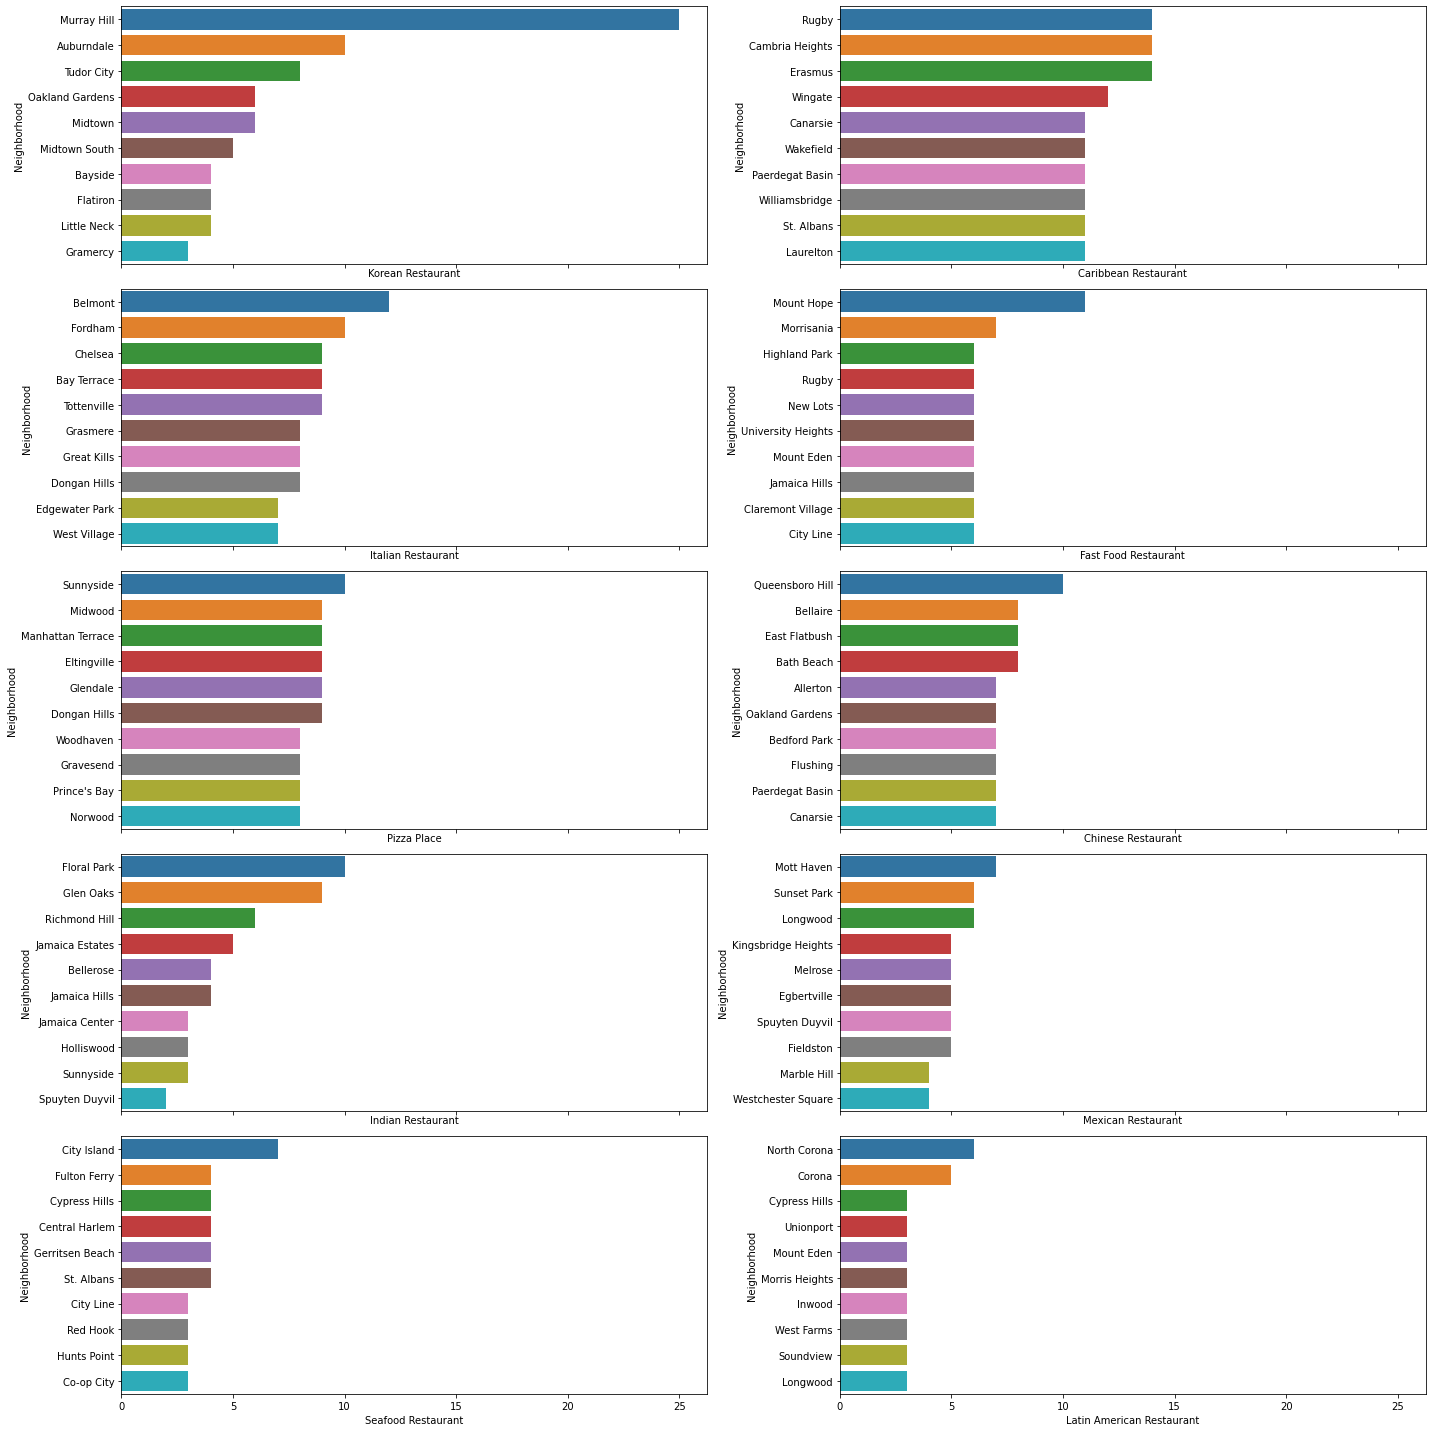

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
#     pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax)

plt.tight_layout()
plt.show();

In [47]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.388889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.357143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.133333,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.142857,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.285714,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.307692,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0

In [48]:
nyc_grouped.shape

(302, 89)

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [51]:
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [52]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Fried Chicken Joint
1,Annadale,Pizza Place,Italian Restaurant,Sushi Restaurant,American Restaurant,Middle Eastern Restaurant
2,Arden Heights,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Chinese Restaurant
3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Polish Restaurant,Peruvian Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Mediterranean Restaurant


In [53]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

In [54]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [55]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

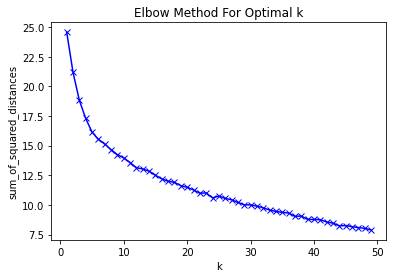

In [59]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [60]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

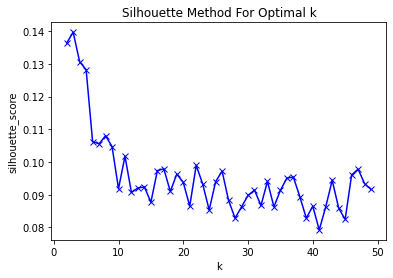

In [61]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(nyc_grouped_clustering)

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_scaled)
# principalComponents

In [ ]:
km = KMeans(init="k-means++", n_clusters=8, n_init=50)
y_km = km.fit_predict(principalComponents)

In [ ]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='o',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_clusters(principalComponents, y_km)

In [ ]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

In [ ]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

In [ ]:
neighborhoods_venues_sorted.head(20)

In [ ]:
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()


In [ ]:
data_csv=nyc_merged[['Clusters','Neighborhood','Borough','Latitude','Longitude','1st Most Common Venue']]

In [ ]:
df_new = data_csv.rename(columns={'1st Most Common Venue': 'Common Venue'})

In [ ]:
df_new.to_csv('finalresult.csv')